# Multi-layer resnet50 from MOSAIKS

## Prepare GeoLife data loader

In [1]:
import os
import sys
import time
import inspect
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import timm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader
from mosaiks_utils import visualize_3d_patches, visTensor, normalize_patches

random_state = np.random.RandomState(0)

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data"  # "/network/scratch/s/sara.ebrahim-elkafrawy/" 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [3]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

trf = torch.nn.Sequential(
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
)

## Define the network

In [4]:
# hyperparameters for the model
mode = 'no_whiten_minibatch' # options ['whiten', 'no_whiten']
whiten = False
save_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/mosaiks_resnet50_{mode}.pt"
max_iter = 3
eps = 1e-4
random_state = np.random.RandomState(0)

### slicing up resnet50
Manually set the indices of all convolution layers and the afterwards activation layers

In [5]:
model    = timm.create_model(model_name = 'resnet50', pretrained = True)
model.fc = nn.Linear(2048, num_species)

In [6]:
# set the weights for hte first layer
# list(model.named_parameters())[0][1].data = torch.from_numpy(kmeans.cluster_centers_.reshape(64, 3, 7, 7))

## extract all conv layers

In [7]:
# for name, param in model.named_parameters():
#     print(name, param.shape)

In [8]:
conv_lyrs = []
idx = 0
for name, param in model.named_parameters():
    if 'conv' in name:
        conv_lyrs.append(idx)
    idx += 1

In [9]:
# conv_lyrs

In [10]:
# for l in conv_lyrs:
#     print(list(model.named_parameters())[l][1].data.shape)

### Hook the activation layers

In [11]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [12]:
model.act1.register_forward_hook(get_features('conv_layer_0'))  #model.layer1[1].act2

model.layer1[0].act1.register_forward_hook(get_features('conv_layer_3'))
model.layer1[0].act2.register_forward_hook(get_features('conv_layer_6'))
model.layer1[0].act3.register_forward_hook(get_features('conv_layer_9'))

model.layer1[1].act1.register_forward_hook(get_features('conv_layer_15'))
model.layer1[1].act2.register_forward_hook(get_features('conv_layer_18'))
model.layer1[1].act3.register_forward_hook(get_features('conv_layer_21'))

model.layer1[2].act1.register_forward_hook(get_features('conv_layer_24'))
model.layer1[2].act2.register_forward_hook(get_features('conv_layer_27'))
model.layer1[2].act3.register_forward_hook(get_features('conv_layer_30'))

model.layer2[0].act1.register_forward_hook(get_features('conv_layer_33'))
model.layer2[0].act2.register_forward_hook(get_features('conv_layer_36'))
model.layer2[0].act3.register_forward_hook(get_features('conv_layer_39'))

model.layer2[1].act1.register_forward_hook(get_features('conv_layer_45'))
model.layer2[1].act2.register_forward_hook(get_features('conv_layer_48'))
model.layer2[1].act3.register_forward_hook(get_features('conv_layer_51'))

model.layer2[2].act1.register_forward_hook(get_features('conv_layer_54'))
model.layer2[2].act2.register_forward_hook(get_features('conv_layer_57'))
model.layer2[2].act3.register_forward_hook(get_features('conv_layer_60'))

model.layer2[3].act1.register_forward_hook(get_features('conv_layer_63'))
model.layer2[3].act2.register_forward_hook(get_features('conv_layer_66'))
model.layer2[3].act3.register_forward_hook(get_features('conv_layer_69'))

model.layer3[0].act1.register_forward_hook(get_features('conv_layer_72'))
model.layer3[0].act2.register_forward_hook(get_features('conv_layer_75'))
model.layer3[0].act3.register_forward_hook(get_features('conv_layer_78'))

model.layer3[1].act1.register_forward_hook(get_features('conv_layer_84'))
model.layer3[1].act2.register_forward_hook(get_features('conv_layer_87'))
model.layer3[1].act3.register_forward_hook(get_features('conv_layer_90'))
    
model.layer3[2].act1.register_forward_hook(get_features('conv_layer_93'))
model.layer3[2].act2.register_forward_hook(get_features('conv_layer_96'))
model.layer3[2].act3.register_forward_hook(get_features('conv_layer_99'))
    
model.layer3[3].act1.register_forward_hook(get_features('conv_layer_102'))
model.layer3[3].act2.register_forward_hook(get_features('conv_layer_105'))
model.layer3[3].act3.register_forward_hook(get_features('conv_layer_108'))

model.layer3[4].act1.register_forward_hook(get_features('conv_layer_111'))
model.layer3[4].act2.register_forward_hook(get_features('conv_layer_114'))
model.layer3[4].act3.register_forward_hook(get_features('conv_layer_117'))

model.layer3[5].act1.register_forward_hook(get_features('conv_layer_120'))
model.layer3[5].act2.register_forward_hook(get_features('conv_layer_123'))
model.layer3[5].act3.register_forward_hook(get_features('conv_layer_126'))    

model.layer4[0].act1.register_forward_hook(get_features('conv_layer_129'))
model.layer4[0].act2.register_forward_hook(get_features('conv_layer_132'))
model.layer4[0].act3.register_forward_hook(get_features('conv_layer_135'))    

model.layer4[1].act1.register_forward_hook(get_features('conv_layer_141'))
model.layer4[1].act2.register_forward_hook(get_features('conv_layer_144'))
model.layer4[1].act3.register_forward_hook(get_features('conv_layer_147'))    

model.layer4[2].act1.register_forward_hook(get_features('conv_layer_150'))
model.layer4[2].act2.register_forward_hook(get_features('conv_layer_153'))
model.layer4[2].act3.register_forward_hook(get_features('conv_layer_156'))    

In [13]:
for layer_idx, conv_idx in enumerate(conv_lyrs):

    if layer_idx == len(conv_lyrs):
        break
        
    print(f'for conv layer idx#{conv_idx}')
    
    curr_param_sz = list(model.named_parameters())[conv_idx][1].data.shape
    
    num_feats = curr_param_sz[0]
    num_ch = curr_param_sz[1]
    patch_size = (curr_param_sz[2], curr_param_sz[3])
    num_iters = max_iter   # The online learning part: cycle over the whole dataset 6 times
    max_patches = int(num_feats/4)

    print(f'num_feats:{num_feats}, num_ch:{num_ch}, patch_size:{patch_size}')
    print(f'curr_param_sz:{curr_param_sz}')

    kmeans = MiniBatchKMeans(n_clusters=num_feats, 
                             random_state=random_state,
                             verbose=True)

    geo_train_loader = DataLoader(
                    geo_train_dataset,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                    pin_memory=True,
                )

    index = 0
    buffer = []

    print(f'activation output after conv_layer_#{conv_lyrs[layer_idx-1]}')
    
    for _ in range(num_iters):
        for batch in geo_train_loader:
            
            patches, target, meta = batch
            
            # this is trf_stand: means standardization with the GeoLife stats
            patches['rgb'] = trf(patches['rgb'])
            _ = model(patches['rgb'])
            
            if layer_idx == 0:
                curr_feats = patches['rgb'].numpy()
            else:
                curr_feats = features_dim[f'conv_layer_{conv_lyrs[layer_idx-1]}'].numpy() 
            
            
            curr_feats = curr_feats.squeeze(0)
            curr_feats = curr_feats.transpose((1,2,0))

            # expects image shape of (width, height, n_channels)
            data = extract_patches_2d(curr_feats, 
                                      patch_size, 
                                      max_patches=max_patches,
                                      random_state=random_state)
            data = np.reshape(data, (len(data), -1))
            buffer.append(data)
            index += 1

            if index % int(len(geo_train_loader)/10) == 0:
                
                data = np.concatenate(buffer, axis=0)
                
                if np.any(np.isnan(data)):
                    data = np.nan_to_num(data)
                    
                # for ReLU zero values
                data[np.where(data == 0)] = eps
                
                data, means, zca_mat = normalize_patches(data, whiten=whiten)
#                 data = np.dot(data, np.linalg.inv(zca_mat))

                kmeans.partial_fit(data)
                buffer = []
            if index % 10000 == 0:
                print("Partial fit of %4i out of %i" % (index, num_iters * len(geo_train_loader)))


    # change the weights of the corresponding conv layer
    print(f'Updating parameter idx#{conv_idx} with size: {curr_param_sz}')
    list(model.named_parameters())[conv_idx][1].data = torch.from_numpy(
        kmeans.cluster_centers_.reshape(
                                            num_feats, 
                                            patch_size[0], 
                                            patch_size[1],
                                            num_ch,).transpose(0, 3, 1, 2)
                                        )


    # save the model
    torch.save(model.state_dict(), save_path)


for conv layer idx#0
num_feats:64, num_ch:3, patch_size:(7, 7)
curr_param_sz:torch.Size([64, 3, 7, 7])
activation output after conv_layer_#156
Updating parameter idx#0 with size: torch.Size([64, 3, 7, 7])
for conv layer idx#3
num_feats:64, num_ch:64, patch_size:(1, 1)
curr_param_sz:torch.Size([64, 64, 1, 1])
activation output after conv_layer_#0
[MiniBatchKMeans] Reassigning 1 cluster centers.
Updating parameter idx#3 with size: torch.Size([64, 64, 1, 1])
for conv layer idx#6
num_feats:64, num_ch:64, patch_size:(3, 3)
curr_param_sz:torch.Size([64, 64, 3, 3])
activation output after conv_layer_#3
[MiniBatchKMeans] Reassigning 1 cluster centers.
Updating parameter idx#6 with size: torch.Size([64, 64, 3, 3])
for conv layer idx#9
num_feats:256, num_ch:64, patch_size:(1, 1)
curr_param_sz:torch.Size([256, 64, 1, 1])
activation output after conv_layer_#6
[MiniBatchKMeans] Reassigning 8 cluster centers.
[MiniBatchKMeans] Reassigning 1 cluster centers.
Updating parameter idx#9 with size: torch.

## Visualize the filters for the first layer

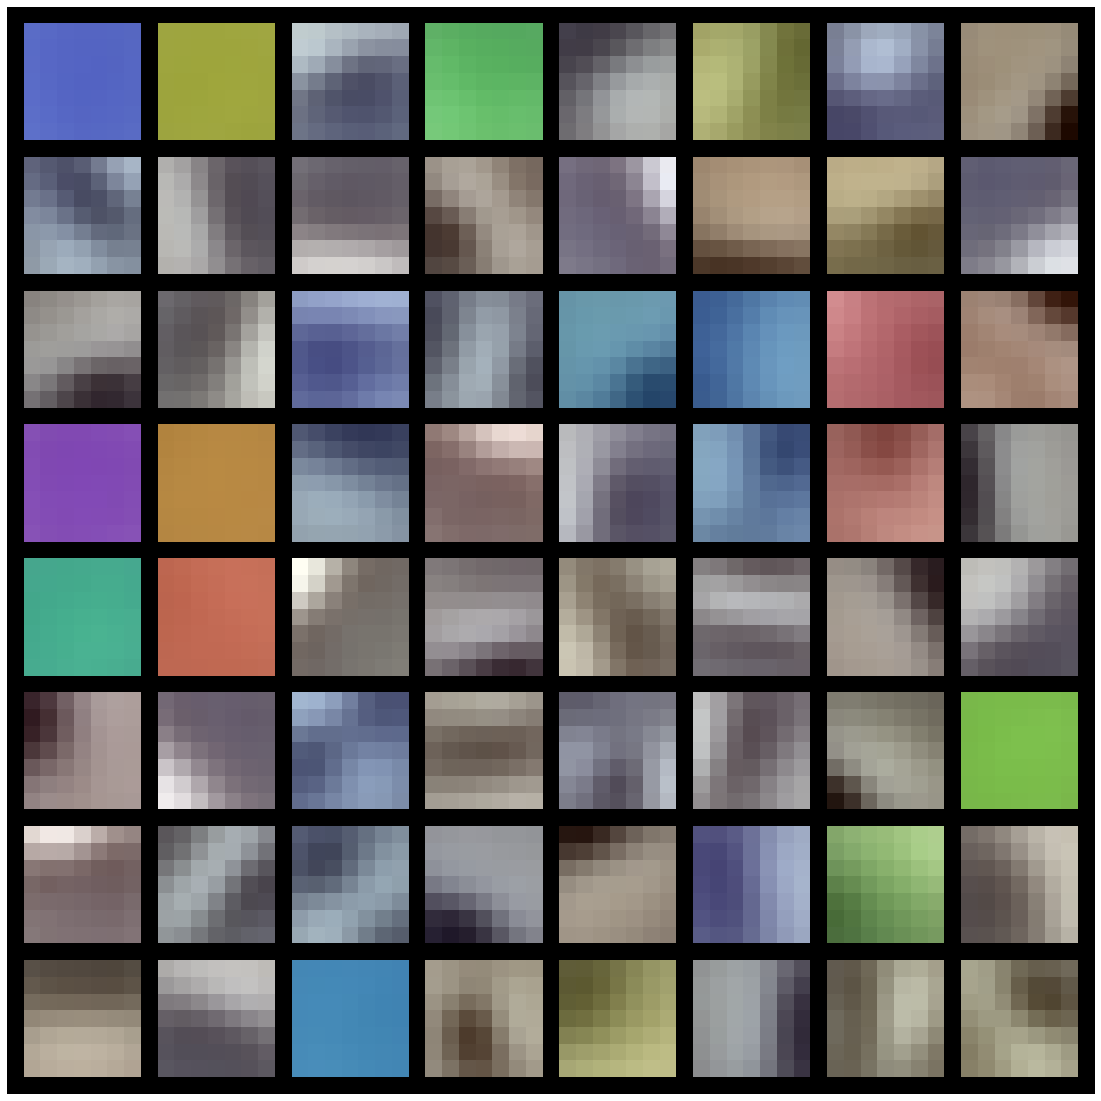

In [17]:
visTensor(list(model.named_parameters())[0][1].data, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='white'
plt.savefig(f'conv1_resnet50_{mode}_color.png')
plt.show()

## Debug the shapes

In [6]:
model_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/mosaiks_resnet50_no_whiten_minibatch.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data.numpy()).sum()}')

In [12]:
check_weights(list(model.named_parameters())[0][1].data)

min: -0.1891670823097229
max: 0.1850183755159378
mean: -6.588948830987817e-10
std: 0.055229395627975464
num_complex numbers: 0


In [ ]:
# for layer_idx, conv_idx in enumerate(conv_lyrs):

#     if layer_idx == len(conv_lyrs):
#         break
        
#     print(f'for conv layer idx#{conv_idx}')
    
#     curr_param_sz = list(model.named_parameters())[conv_idx][1].data.shape
    
#     num_feats = curr_param_sz[0]
#     num_ch = curr_param_sz[1]
#     patch_size = (curr_param_sz[2], curr_param_sz[3])
#     num_iters = max_iter   # The online learning part: cycle over the whole dataset 6 times
#     max_patches = int(num_feats/4)

#     print(f'num_feats:{num_feats}, num_ch:{num_ch}, patch_size:{patch_size}')
#     print(f'curr_param_sz:{curr_param_sz}')

#     geo_train_loader = DataLoader(
#                     geo_train_dataset,
#                     batch_size=batch_size,
#                     num_workers=num_workers,
#                     shuffle=True,
#                     pin_memory=True,
#                 )

#     index = 0
#     buffer = []

#     patches, target, meta = next(iter(geo_train_loader))

#     # this is trf_stand: means standardization with the GeoLife stats
#     patches['rgb'] = trf(patches['rgb'])
#     _ = model(patches['rgb'])

#     if layer_idx == 0:
#         curr_feats = patches['rgb'].numpy()
#     else:
#         print(f'activation output after conv_layer_#{conv_lyrs[layer_idx-1]}')
#         curr_feats = features_dim[f'conv_layer_{conv_lyrs[layer_idx-1]}'].numpy()  



#     print(f'curr_feats: {curr_feats.shape}')
#     curr_feats = curr_feats.squeeze(0)
#     curr_feats = curr_feats.transpose((1,2,0))

#     # expects image shape of (width, height, n_channels)
#     data = extract_patches_2d(curr_feats, 
#                               patch_size, 
#                               max_patches=max_patches,
#                               random_state=random_state)
#     data = np.reshape(data, (len(data), -1))
#     buffer.append(data)
#     index += 1

#     tmp = np.random.random((num_feats, num_ch*patch_size[0]*patch_size[1]))

#     # change the weights of the corresponding conv layer
#     print(f'Updating parameter idx#{conv_idx} with size: {curr_param_sz}')
#     tmp_tensor = torch.from_numpy(tmp.reshape(
#                                         num_feats, 
#                                         patch_size[0], 
#                                         patch_size[1],
#                                         num_ch,).transpose(0, 3, 1, 2))
#     tmp_tensor = tmp_tensor.type(torch.FloatTensor)
#     list(model.named_parameters())[conv_idx][1].data =  tmp_tensor


